# Making a convolutional autoencoder to denoise images

In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
from tqdm import tqdm
import random
from typing import List, Tuple, Literal
import torch.nn as nn
from torch.utils.data import Dataset

In [2]:
class NoisyMNISTDataset(Dataset):
    """
    Custom Dataset for MNIST with noisy data.

    Args:
        data (np.ndarray): Original MNIST data (images).
        labels (np.ndarray): MNIST labels corresponding to the data.
        noise_types (list): List of noise types to apply : ['gaussian', 's&p', 'poisson', 'speckle']
    """

    def __init__(
        self,
        data: np.ndarray,
        labels: np.ndarray,
        noise_types: Literal["gaussian", "s&p", "poisson", "speckle"],
    ) -> None:
        # convert to tensor and add channel dim
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
        self.labels = labels
        self.noisy_data = self._add_noise(data, noise_types)
        self.noisy_data = torch.tensor(self.noisy_data, dtype=torch.float32).unsqueeze(
            1
        )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.noisy_data[idx], self.data[idx]

    def _add_noise(self, data: np.ndarray, noise_types: list) -> np.ndarray:
        """
        Adds noise to the input data using different noise modes.
        """
        new_data = np.copy(data)
        for i, image in enumerate(new_data):
            print(f"Adding noise: {i + 1}/{len(new_data)}", end="\r")
            if "gaussian" in noise_types:
                image = random_noise(image, mode="gaussian", mean=0, var=0.1)
            if "s&p" in noise_types:
                image = random_noise(image, mode="s&p", amount=0.05, salt_vs_pepper=0.5)
            if "poisson" in noise_types:
                image = random_noise(image, mode="poisson")
            if "speckle" in noise_types:
                image = random_noise(image, mode="speckle", mean=0, var=0.05)
            new_data[i] = np.clip(image, 0, 1)
        print("Noise added.")
        return new_data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.numpy().squeeze())]
)
mnist_data = datasets.MNIST(
    root="../data", download=True, transform=transform, train=True
)
data, labels = mnist_data.data.numpy(), mnist_data.targets.numpy()
data = data / 255.0
noisy_dataset = NoisyMNISTDataset(
    data, labels, noise_types=["gaussian", "s&p", "poisson", "speckle"]
)
print(f"Dataset size: {len(noisy_dataset)}")

Noise added.: 60000/60000
Dataset size: 60000


Noisy Image Shape: torch.Size([1, 28, 28])
Clean Image Shape: torch.Size([1, 28, 28])


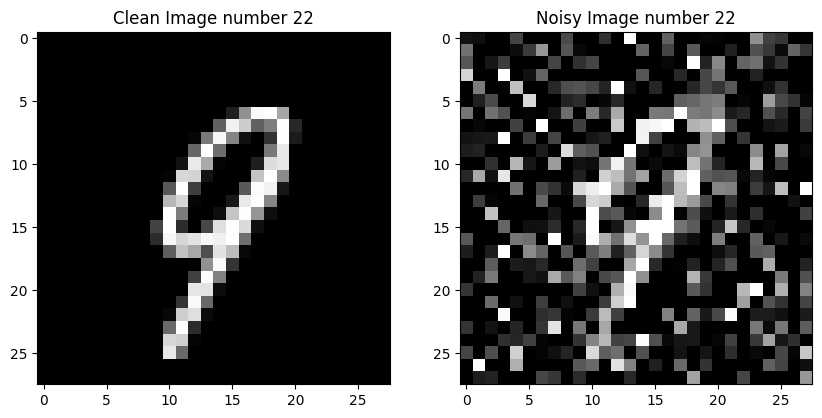

In [4]:
idx = 22
noisy_image, clean_image = noisy_dataset[idx]
print("Noisy Image Shape:", noisy_image.shape)
print("Clean Image Shape:", clean_image.shape)
noisy_image_np = noisy_image.squeeze().numpy()
clean_image_np = clean_image.squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].imshow(noisy_image_np, cmap="gray")
ax[1].set_title(f"Noisy Image number {idx}")
ax[0].imshow(clean_image_np, cmap="gray")
ax[0].set_title(f"Clean Image number {idx}")
plt.show()

In [5]:
random.seed(22)
torch.manual_seed(22)
train_size = int(0.8 * len(noisy_dataset))
test_size = len(noisy_dataset) - train_size
train_dataset, test_dataset = random_split(noisy_dataset, [train_size, test_size])
train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
train_size = len(train_dataset)
test_size = len(test_dataset)
print(f"Number of samples in the training set: {train_size}")
print(f"Number of samples in the test set: {test_size}")

Number of samples in the training set: 48000
Number of samples in the test set: 12000


In [7]:
class DenoiserAutoEncoder(nn.Module):
    """
    Denoiser AutoEncoder model for reconstructing clean images from noisy inputs.
    - The encoder compresses the input image to a lower-dimensional representation.
    - The decoder reconstructs the image from the encoded representation.
    """

    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def test_shapes(self, input_tensor: torch.Tensor) -> None:
        """Check if the reconstructed image has the same shape as the input image."""
        with torch.no_grad():  # no need for gradients during shape testing
            self.eval()
            encoded = self.encoder(input_tensor)
            decoded = self.decoder(encoded)
            assert (
                decoded.shape == input_tensor.shape
            ), f"Shape mismatch: original {input_tensor.shape}, reconstructed {decoded.shape}"
            print(f"Shape match confirmed: {decoded.shape}")

    def save_model(self, file_path: str) -> None:
        """
        Saves the model's state_dict to the specified file path.
        """
        torch.save(self.state_dict(), file_path)
        print(f"Model saved to --> {file_path}")

In [8]:
model = DenoiserAutoEncoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenoiserAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [9]:
input_tensor = torch.randn(1, 1, 28, 28).to(
    device
)  # (batch_size, channels, height, width)
model.test_shapes(input_tensor)

Shape match confirmed: torch.Size([1, 1, 28, 28])


In [10]:
num_epochs: int = 15
outputs: List[float] = []
epoch_train_losses: List[float] = []
epoch_test_losses: List[float] = []

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    progress_bar = tqdm(
        train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True
    )

    for img, _ in progress_bar:
        img = img.to(device)
        # Forward pass
        reconstructed_img = model(img)
        loss = criterion(reconstructed_img, img)
        # bakcpop and optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.5f}")

    # avg training losses
    avg_train_loss = epoch_train_loss / len(train_data_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f"Epoch: {epoch+1} | Avg Train Loss: {avg_train_loss:.5f}")
    outputs.append((epoch, img, reconstructed_img))
    # testing (no gradients needed)
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for img, _ in test_data_loader:
            img = img.to(device)
            reconstructed_img = model(img)
            loss = criterion(reconstructed_img, img)
            epoch_test_loss += loss.item()

    # avg test losses
    avg_test_loss = epoch_test_loss / len(test_data_loader)
    epoch_test_losses.append(avg_test_loss)
    print(f"Epoch: {epoch+1} | Avg Test Loss: {avg_test_loss:.5f}")

Epoch 1/15: 100%|██████████| 750/750 [00:08<00:00, 90.16it/s, loss=0.05961] 


Epoch: 1 | Avg Train Loss: 0.07303
Epoch: 1 | Avg Test Loss: 0.05815


Epoch 2/15: 100%|██████████| 750/750 [00:10<00:00, 74.75it/s, loss=0.05410]


Epoch: 2 | Avg Train Loss: 0.05537
Epoch: 2 | Avg Test Loss: 0.05354


Epoch 3/15: 100%|██████████| 750/750 [00:16<00:00, 44.55it/s, loss=0.05355]


Epoch: 3 | Avg Train Loss: 0.05301
Epoch: 3 | Avg Test Loss: 0.05269


Epoch 4/15: 100%|██████████| 750/750 [00:13<00:00, 56.20it/s, loss=0.05257]


Epoch: 4 | Avg Train Loss: 0.05240
Epoch: 4 | Avg Test Loss: 0.05219


Epoch 5/15: 100%|██████████| 750/750 [00:13<00:00, 56.30it/s, loss=0.05229]


Epoch: 5 | Avg Train Loss: 0.05203
Epoch: 5 | Avg Test Loss: 0.05186


Epoch 6/15: 100%|██████████| 750/750 [00:12<00:00, 59.93it/s, loss=0.05182]


Epoch: 6 | Avg Train Loss: 0.05178
Epoch: 6 | Avg Test Loss: 0.05170


Epoch 7/15: 100%|██████████| 750/750 [00:11<00:00, 65.11it/s, loss=0.05242]


Epoch: 7 | Avg Train Loss: 0.05161
Epoch: 7 | Avg Test Loss: 0.05153


Epoch 8/15: 100%|██████████| 750/750 [00:12<00:00, 58.98it/s, loss=0.05147]


Epoch: 8 | Avg Train Loss: 0.05148
Epoch: 8 | Avg Test Loss: 0.05146


Epoch 9/15: 100%|██████████| 750/750 [00:13<00:00, 56.73it/s, loss=0.05097]


Epoch: 9 | Avg Train Loss: 0.05137
Epoch: 9 | Avg Test Loss: 0.05136


Epoch 10/15: 100%|██████████| 750/750 [00:13<00:00, 56.27it/s, loss=0.05094]


Epoch: 10 | Avg Train Loss: 0.05128
Epoch: 10 | Avg Test Loss: 0.05125


Epoch 11/15: 100%|██████████| 750/750 [00:13<00:00, 56.52it/s, loss=0.05076]


Epoch: 11 | Avg Train Loss: 0.05119
Epoch: 11 | Avg Test Loss: 0.05116


Epoch 12/15: 100%|██████████| 750/750 [00:13<00:00, 55.90it/s, loss=0.05122]


Epoch: 12 | Avg Train Loss: 0.05112
Epoch: 12 | Avg Test Loss: 0.05112


Epoch 13/15: 100%|██████████| 750/750 [00:12<00:00, 62.38it/s, loss=0.05070]


Epoch: 13 | Avg Train Loss: 0.05106
Epoch: 13 | Avg Test Loss: 0.05107


Epoch 14/15: 100%|██████████| 750/750 [00:11<00:00, 63.58it/s, loss=0.05062]


Epoch: 14 | Avg Train Loss: 0.05101
Epoch: 14 | Avg Test Loss: 0.05105


Epoch 15/15: 100%|██████████| 750/750 [00:12<00:00, 60.55it/s, loss=0.05059]


Epoch: 15 | Avg Train Loss: 0.05096
Epoch: 15 | Avg Test Loss: 0.05099


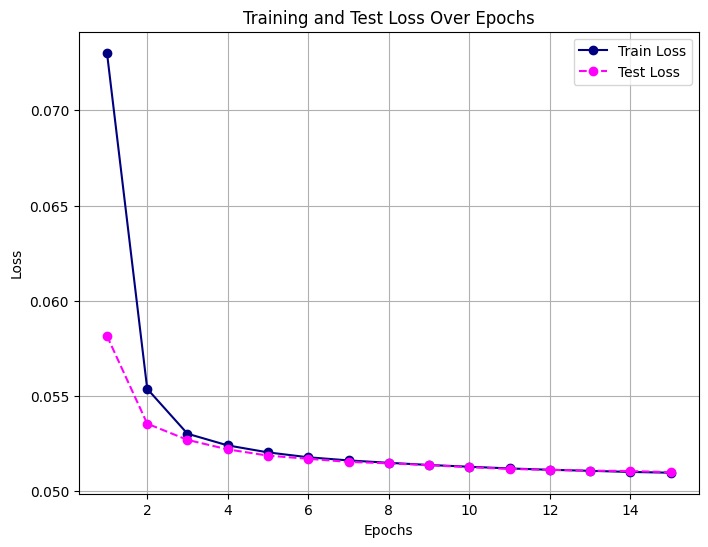

In [11]:
def plot_loss(train_losses: List[float], test_losses: List[float]) -> None:
    plt.figure(figsize=(8, 6))
    plt.plot(
        range(1, len(train_losses) + 1),
        train_losses,
        marker="o",
        linestyle="-",
        color="navy",
        label="Train Loss",
    )
    plt.plot(
        range(1, len(test_losses) + 1),
        test_losses,
        marker="o",
        linestyle="--",
        color="magenta",
        label="Test Loss",
    )
    plt.title("Training and Test Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


plot_loss(epoch_train_losses, epoch_test_losses)

In [12]:
model.save_model("cached_model/denoiser_autoencoder.pth")

Model saved to --> cached_model/denoiser_autoencoder.pth


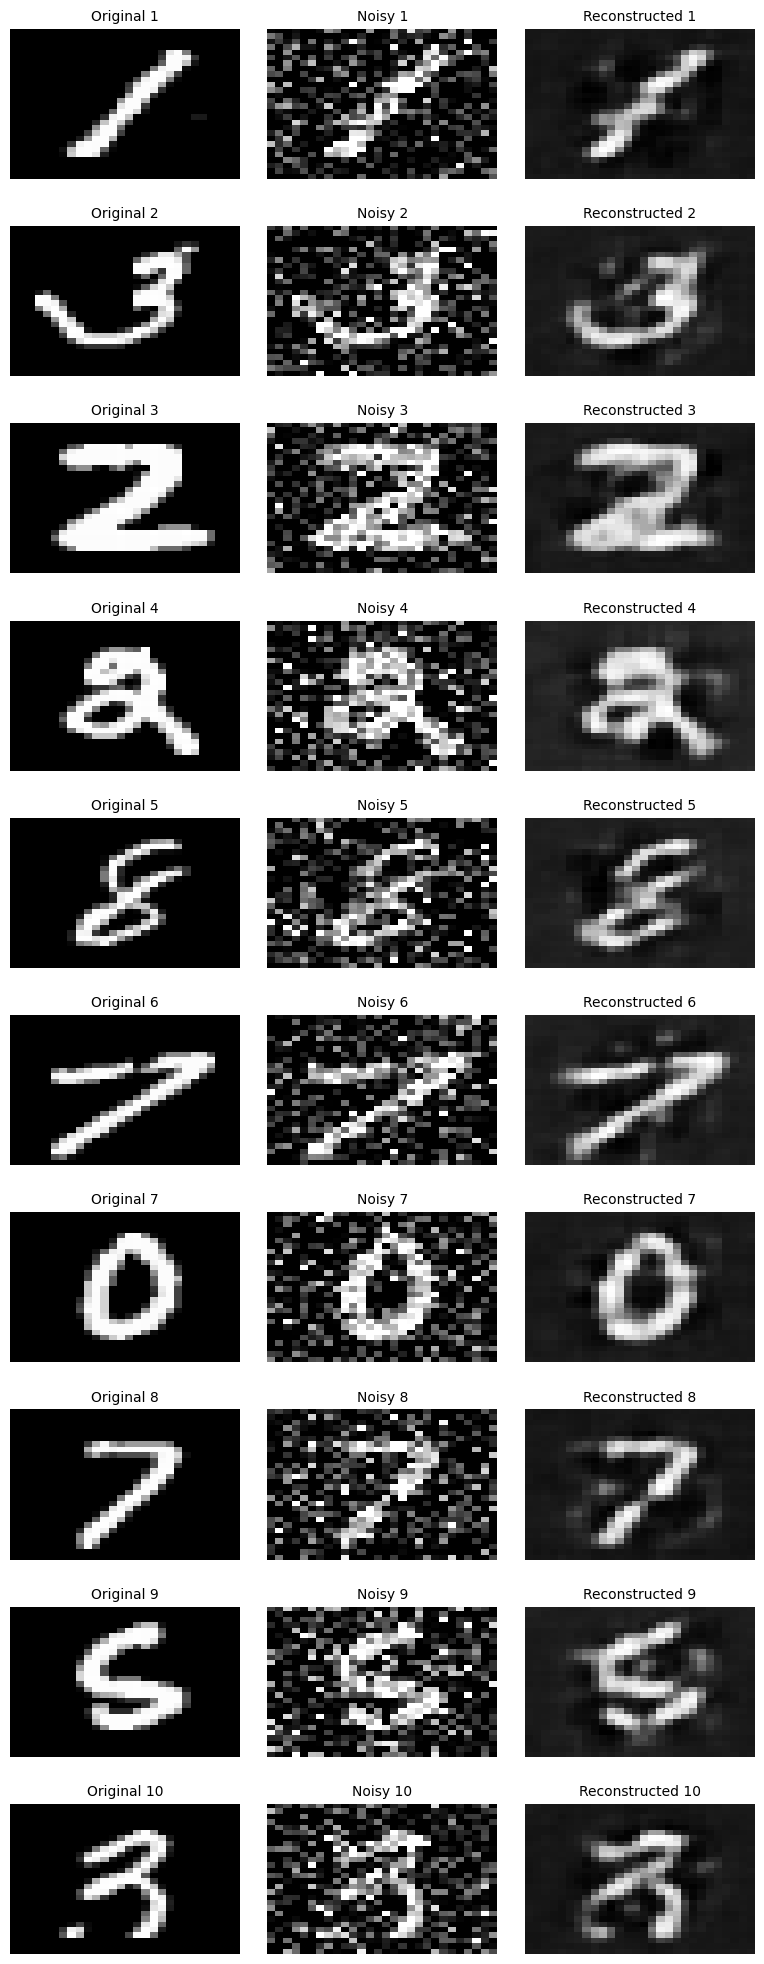

In [13]:
def inference(
    model: DenoiserAutoEncoder,
    data_loader: DataLoader,
    num_samples: int = 10,
    seed: int = 42,
):
    """
    Select `num_samples` random images from the dataset, pass them through the model,
    and visualize the original image, the noisy input image, and the reconstructed image.
    """
    random.seed(seed)
    model.eval()
    with torch.no_grad():
        for noisy_img, original_img in data_loader:
            indices = random.sample(range(noisy_img.size(0)), num_samples)
            noisy_images = noisy_img[indices].to(device)
            original_images = original_img[indices].cpu().numpy()
            # forward pass the img
            reconstructed_img = model(noisy_images)
            reconstructed_images = reconstructed_img.cpu().detach().numpy()
            fig, axes = plt.subplots(num_samples, 3, figsize=(8, 2 * num_samples))
            for i in range(num_samples):
                # og img
                axes[i, 0].imshow(
                    original_images[i].squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 0].set_title(f"Original {i+1}", fontsize=10)
                axes[i, 0].axis("off")
                # noisy img
                axes[i, 1].imshow(
                    noisy_images[i].cpu().numpy().squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 1].set_title(f"Noisy {i+1}", fontsize=10)
                axes[i, 1].axis("off")
                # reconstructed img
                axes[i, 2].imshow(
                    reconstructed_images[i].squeeze(), cmap="gray", aspect="auto"
                )
                axes[i, 2].set_title(f"Reconstructed {i+1}", fontsize=10)
                axes[i, 2].axis("off")
            plt.subplots_adjust(hspace=0.5, wspace=0.5)
            plt.tight_layout(pad=2.0)
            plt.show()
            break  # just the first batch


inference(model, test_data_loader, num_samples=10, seed=23)